# Economic Dispatch Notebook
This notebook assembles the complete workflow:
1. Generate a randomized convex production fleet.
2. Solve stochastic dispatch under Gaussian ("normal") and Chebyshev ("robust") assumptions.
3. Summarize optimal decisions, verify KKT conditions, and visualize the cost/safety trade-offs.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import cvxpy as cp

In [9]:
class ProductionSystem:
    """Container for convex quadratic generators used in stochastic dispatch."""

    def __init__(self, n_machines=5, seed=42,
                 alpha_bounds=(0.05, 0.2), beta_bounds=(2.0, 5.0),
                 gamma_bounds=(10.0, 20.0), capacity_bounds=(50.0, 150.0)):
        rng = np.random.default_rng(seed)
        self.n = n_machines
        self.alpha = rng.uniform(alpha_bounds[0], alpha_bounds[1], n_machines)
        self.beta = rng.uniform(beta_bounds[0], beta_bounds[1], n_machines)
        self.gamma = rng.uniform(gamma_bounds[0], gamma_bounds[1], n_machines)
        self.l = np.zeros(n_machines)
        self.u = rng.uniform(capacity_bounds[0], capacity_bounds[1], n_machines)

    def describe(self):
        machines = np.arange(1, self.n + 1)
        data = {
            "alpha": self.alpha,
            "beta": self.beta,
            "gamma": self.gamma,
            "min_cap": self.l,
            "max_cap": self.u,
        }
        return pd.DataFrame(data, index=machines).rename_axis("machine")

    def total_capacity(self):
        return float(np.sum(self.u))

In [10]:
def solve_dispatch(system, mu_D, sigma_D, reliability=0.95, mode="normal"):
    """Solve the convex economic dispatch under either Gaussian or Chebyshev risk."""

    if sigma_D < 0 or mu_D < 0:
        raise ValueError("Demand statistics must be non-negative")
    if not 0.0 < reliability < 1.0:
        raise ValueError("Reliability must lie in (0,1)")

    x = cp.Variable(system.n)
    alpha_risk = 1.0 - reliability

    if mode == "normal":
        z_score = stats.norm.ppf(reliability)
        D_eff = mu_D + z_score * sigma_D
    elif mode == "robust":
        k_robust = np.sqrt((1 - alpha_risk) / alpha_risk)
        D_eff = mu_D + k_robust * sigma_D
    else:
        raise ValueError("Mode must be 'normal' or 'robust'")

    if D_eff > system.total_capacity() + 1e-6:
        raise ValueError("Effective demand exceeds total installed capacity")

    objective = cp.Minimize(cp.sum(cp.multiply(system.alpha, x**2) + cp.multiply(system.beta, x)))

    c_demand = [cp.sum(x) >= D_eff]
    c_upper = [x <= system.u]
    c_lower = [x >= system.l]
    constraints = c_demand + c_upper + c_lower

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)

    if prob.status not in {"optimal", "optimal_inaccurate"}:
        return {"status": prob.status}

    dispatch = x.value
    total_cost = float(np.sum(system.alpha * dispatch**2 + system.beta * dispatch + system.gamma))

    return {
        "status": prob.status,
        "x": dispatch,
        "cost": total_cost,
        "objective": prob.value,
        "D_eff": float(D_eff),
        "lambda": c_demand[0].dual_value,
        "nu_u": c_upper[0].dual_value,
        "nu_l": c_lower[0].dual_value,
    }

In [11]:
def verify_kkt(system, res, tol=1e-4):
    """Return basic KKT residuals for stationarity and slackness."""

    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        print("Cannot verify KKT: solution unavailable.")
        return {}

    dispatch = res["x"]
    lam = res["lambda"]
    nu_u = res["nu_u"]
    nu_l = res["nu_l"]

    grad_f = 2 * system.alpha * dispatch + system.beta
    stationarity_residual = grad_f - lam + nu_u - nu_l
    max_stationarity = float(np.max(np.abs(stationarity_residual)))

    total_prod = float(np.sum(dispatch))
    slack = total_prod - res["D_eff"]
    comp_slack_error = float(abs(slack * lam))

    print("\n--- KKT CHECK ---")
    print(f"Stationarity residual: {max_stationarity:.2e}")
    print(f"Complementary slackness residual: {comp_slack_error:.2e}")

    if max_stationarity < tol and comp_slack_error < tol:
        print("KKT conditions satisfied within tolerance.")
    else:
        print("Warning: residuals exceed tolerance.")

    return {"stationarity": max_stationarity, "slackness": comp_slack_error}

### Results And Analysis

In [12]:
def summarize_dispatch(system, res):
    if res.get("status") not in {"optimal", "optimal_inaccurate"}:
        raise ValueError("Cannot summarize infeasible solution")

    dispatch = res["x"]
    table = system.describe().copy()
    table["dispatch"] = dispatch
    table["upper_slack"] = system.u - dispatch
    table["lower_slack"] = dispatch - system.l
    table["nu_upper"] = res["nu_u"]
    table["nu_lower"] = res["nu_l"]
    table["marginal_cost"] = 2 * system.alpha * dispatch + system.beta
    table["incremental_cost"] = system.alpha * dispatch**2 + system.beta * dispatch + system.gamma
    return table

In [13]:
# Scenario comparison for Gaussian vs. Chebyshev hedging
system = ProductionSystem(n_machines=6, seed=7)
mu_D = 350.0
sigma_D = 40.0
reliability = 0.95

print("Generator parameters (USD & MW):")
print(system.describe())

results = {}
summaries = {}
for mode in ("normal", "robust"):
    print(f"\n=== {mode.title()} dispatch ===")
    res = solve_dispatch(system, mu_D, sigma_D, reliability=reliability, mode=mode)
    results[mode] = res
    summary = summarize_dispatch(system, res)
    summaries[mode] = summary
    print(f"Effective demand: {res['D_eff']:.1f} MW")
    print(f"Total cost: ${res['cost']:.2f}")
    print(summary[["dispatch", "max_cap", "marginal_cost"]])
    verify_kkt(system, res)


Generator parameters (USD & MW):
            alpha      beta      gamma  min_cap     max_cap
machine                                                    
1        0.143764  2.015796  12.548696      0.0  112.217923
2        0.184582  4.463685  14.450763      0.0  148.896015
3        0.166353  4.391208  15.045483      0.0   71.530870
4        0.083781  3.403805  15.534974      0.0   66.021203
5        0.095025  2.909097  19.955003      0.0  111.253960
6        0.181033  2.835277  17.926619      0.0   54.394201

=== Normal dispatch ===
Effective demand: 415.8 MW
Total cost: $5359.32
           dispatch     max_cap  marginal_cost
machine                                       
1         75.517454  112.217923      23.729227
2         52.186926  148.896015      23.729227
3         58.123495   71.530870      23.729227
4         66.021203   66.021203      14.466460
5        109.550866  111.253960      23.729227
6         54.394201   54.394201      22.529569

--- KKT CHECK ---
Stationarity residu

## Scenario Setup and Solver Outputs
We instantiate six generators (seed = 7) and evaluate a demand profile with mean 350 MW, standard deviation 40 MW, and reliability target 95%. The code below solves both the Gaussian chance-constrained model (`mode="normal"`) and the Chebyshev-style robust model (`mode="robust"`). Each block prints the effective demand (risk-adjusted requirement), total system cost, machine-level dispatch table, and KKT residuals.

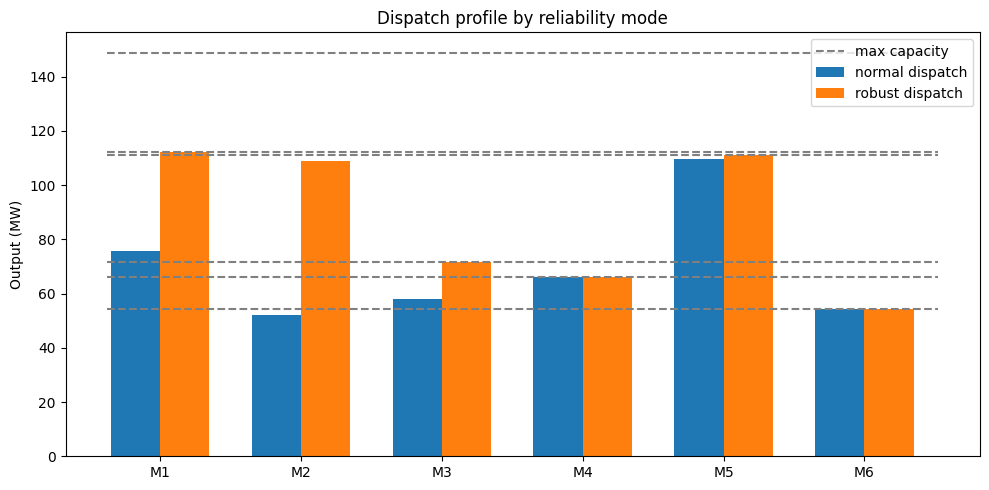

In [14]:
# Visual comparison of dispatch decisions
modes = list(summaries.keys())
indices = np.arange(system.n)
width = 0.35

plt.figure(figsize=(10, 5))
for i, mode in enumerate(modes):
    plt.bar(indices + i * width, summaries[mode]["dispatch"], width, label=f"{mode} dispatch")

plt.hlines(system.u, xmin=-0.2, xmax=indices[-1] + len(modes) * width, colors="gray", linestyles="dashed", label="max capacity")
plt.xticks(indices + width / 2, [f"M{i+1}" for i in indices])
plt.ylabel("Output (MW)")
plt.title("Dispatch profile by reliability mode")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
def plot_allocation(system, res, title="Optimal Resource Allocation"):
    """Bar chart comparing dispatch to installed capacity per generator."""
    indices = np.arange(system.n)

    plt.figure(figsize=(10, 5))
    plt.bar(indices, system.u, color="lightgray", label="Capacity", hatch="//", edgecolor="gray")

    colors = []
    for i, val in enumerate(res["x"]):
        if val >= system.u[i] - 1e-3:
            colors.append("forestgreen")
        elif val <= 1e-3:
            colors.append("lightcoral")
        else:
            colors.append("royalblue")

    plt.bar(indices, res["x"], color=colors, label="Dispatch")
    plt.xlabel("Machine ID")
    plt.ylabel("Output (MW)")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


def plot_comparison(res_norm, res_rob):
    """Side-by-side comparison of cost and demand buffers."""
    labels = ["Normal (Gaussian)", "Robust (Chebyshev)"]
    costs = [res_norm["cost"], res_rob["cost"]]
    targets = [res_norm["D_eff"], res_rob["D_eff"]]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    bars = ax1.bar(labels, costs, color=["steelblue", "firebrick"], alpha=0.8)
    ax1.set_ylabel("Total Operating Cost ($)")
    ax1.set_title("Cost impact of robustness")
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height,
                 f"${height:,.0f}", ha="center", va="bottom", fontweight="bold")

    ax2.bar(labels, targets, color=["skyblue", "salmon"], alpha=0.8)
    ax2.set_ylabel("Effective demand (MW)")
    ax2.set_title("Reliability buffer requirements")
    gap = targets[1] - targets[0]
    ax2.annotate(f"+{gap:.1f} MW buffer", xy=(1, targets[1]), xytext=(0.5, targets[1]),
                 arrowprops=dict(facecolor="black", arrowstyle="->"))

    plt.tight_layout()
    plt.show()


def plot_sensitivity(system, mu, sigma):
    """Trace how cost grows as reliability increases toward 100%."""
    alphas = [0.10, 0.05, 0.02, 0.01, 0.005]
    reliabilities = [(1 - a) * 100 for a in alphas]
    costs = []
    for a in alphas:
        res = solve_dispatch(system, mu, sigma, reliability=1 - a, mode="normal")
        costs.append(res["cost"])

    plt.figure(figsize=(8, 5))
    plt.plot(reliabilities, costs, marker="o", linewidth=2, color="purple")
    plt.xlabel("Target reliability (%)")
    plt.ylabel("Total cost ($)")
    plt.title("Sensitivity of cost to reliability")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.annotate("Diminishing returns",
                 xy=(reliabilities[-2], costs[-2]),
                 xytext=(reliabilities[-3], costs[-1]),
                 arrowprops=dict(facecolor="black", shrink=0.05))
    plt.tight_layout()
    plt.show()

## Visualization Summary
The following plots interpret the numerical results:
- **Allocation bars:** compare dispatch vs. capacity for each generator under both reliability modes, highlighting saturated (green) vs. partially used (blue) units.
- **Cost vs. buffer comparison:** shows how the robust model raises both effective demand and total cost to guarantee the same 95% reliability without assuming Gaussian demand.
- **Reliability sensitivity:** traces the exponential increase in operating cost as the reliability target approaches perfection, emphasizing diminishing returns beyond ~99%. Run the cell to regenerate the figures with current parameters.

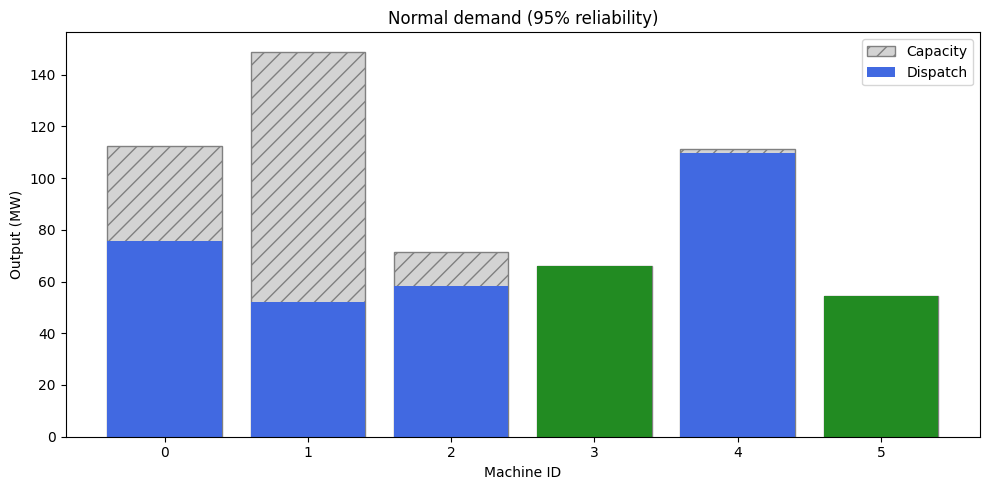

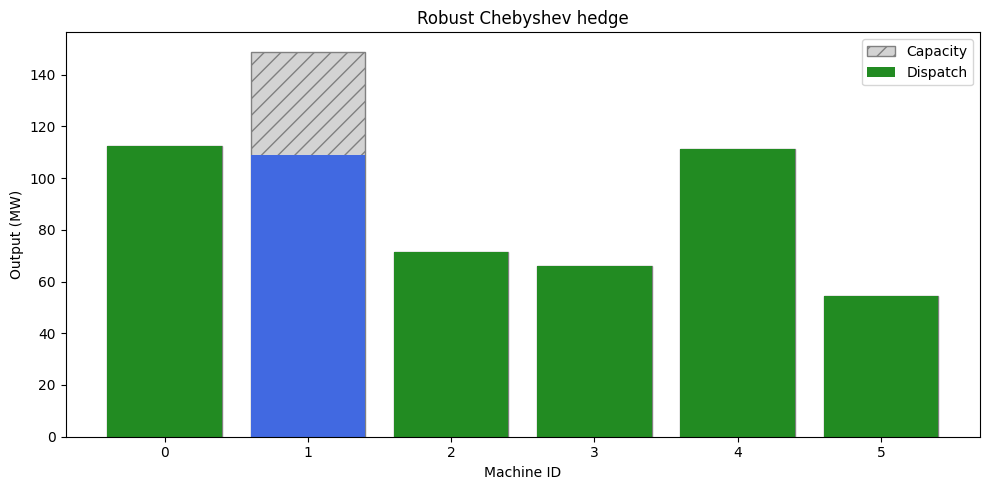

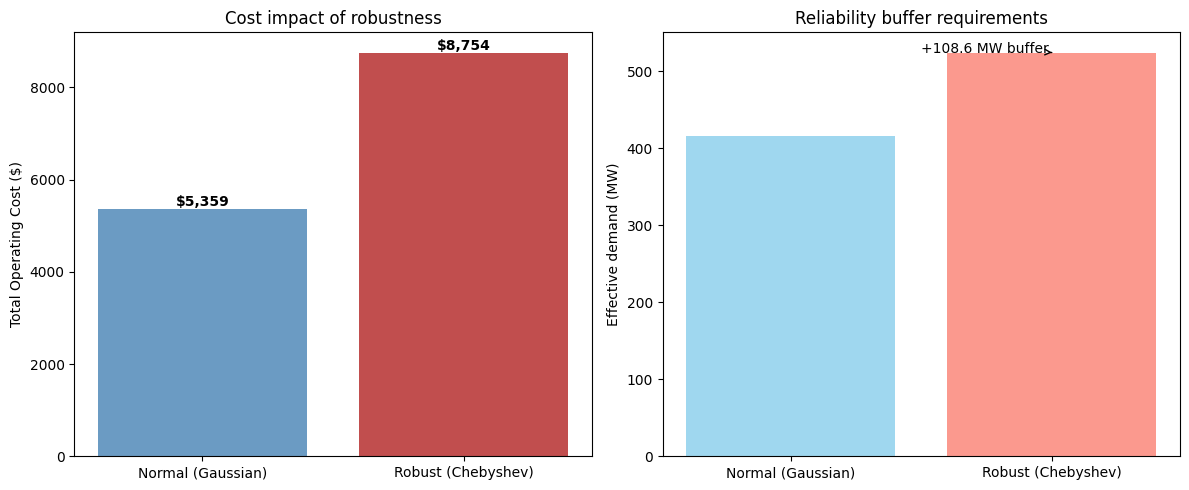

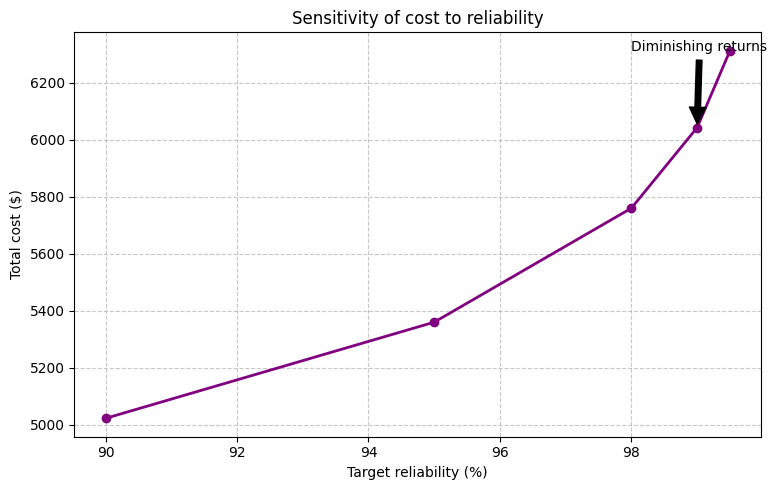

In [16]:
res_norm = results["normal"]
res_rob = results["robust"]

plot_allocation(system, res_norm, "Normal demand (95% reliability)")
plot_allocation(system, res_rob, "Robust Chebyshev hedge")
plot_comparison(res_norm, res_rob)
plot_sensitivity(system, mu_D, sigma_D)